In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin

import keras
from  keras.preprocessing.image import ImageDataGenerator

import os
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


In [2]:
%ls /kaggle/input/digits_sneakers_sandals/

data_digits_8_vs_9_noisy/  data_sneaker_vs_sandal/


# Digits

In [3]:
root_dir = '/kaggle/input/digits_sneakers_sandals/'

X_train = pd.read_csv(os.path.join(root_dir, 'data_digits_8_vs_9_noisy/x_train.csv'))
X_test = pd.read_csv(os.path.join(root_dir, 'data_digits_8_vs_9_noisy/x_test.csv'))
Y_train = pd.read_csv(os.path.join(root_dir, 'data_digits_8_vs_9_noisy/y_train.csv'))
Y_test = pd.read_csv(os.path.join(root_dir, 'data_digits_8_vs_9_noisy/y_test.csv'))

X_train, Y_train, X_test, Y_test = X_train.values, Y_train.values, X_test.values, Y_test.values

print('Train/Test Sizes : ', X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

Train/Test Sizes :  (11800, 784) (11800, 1) (1983, 784) (1983, 1)


In [4]:
%%time

train_losses, test_losses, train_accuracy, test_accuracy = [], [], [], []
coefs = []

for i in range(1,41):
    lr = LogisticRegression(solver='liblinear', max_iter=i)
    lr.fit(X_train, Y_train)
    train_accuracy.append(lr.score(X_train, Y_train))
    test_accuracy.append(lr.score(X_test, Y_test))
    train_losses.append(log_loss(Y_train, lr.predict(X_train)))
    test_losses.append(log_loss(Y_test, lr.predict(X_test)))
    coefs.append(lr.coef_[0][0])

CPU times: user 1min 18s, sys: 1.42 s, total: 1min 20s
Wall time: 1min 18s


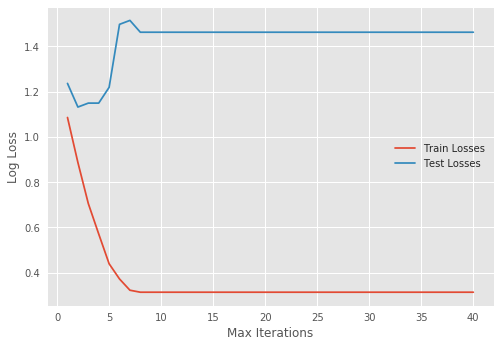

In [5]:
with plt.style.context(('seaborn', 'ggplot')):
    plt.plot(range(1,41), train_losses, label='Train Losses')
    plt.plot(range(1,41), test_losses, label='Test Losses')
    plt.xlabel('Max Iterations')
    plt.ylabel('Log Loss')
    plt.legend(loc='best')

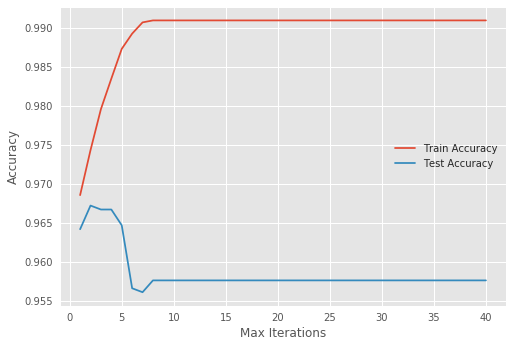

In [6]:
with plt.style.context(('seaborn', 'ggplot')):
    plt.plot(range(1,41), train_accuracy, label='Train Accuracy')
    plt.plot(range(1,41), test_accuracy, label='Test Accuracy')
    plt.xlabel('Max Iterations')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

1

From above results we can see that test accuracy increases only till first 2 max iterations. It then decreases wherease train accuracy keeps increasing even after that as well. After 7-8 max iterations both train and test accuracies stops improving and settles down.

We can see same trend in loss plot as well. Test loss decreases for 2 max iteration and then it increases again.  Train loss keeps on decreasing until 7-8 max iterations and then it settles down. Test loss also decreases after 7-8 epochs.

We feel that model is converging after 7-8 max iterations and then its not improving much hence its not able to decrease loss or improve accuracy.

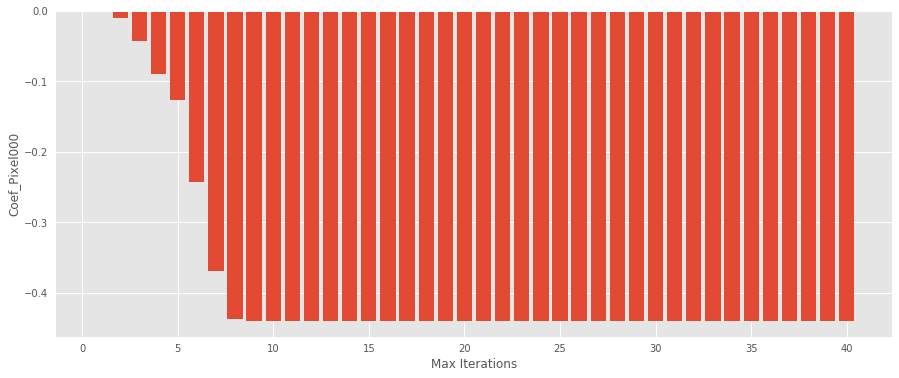

In [7]:
with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(15,6))
    plt.bar(range(1,41), coefs)
    plt.xlabel('Max Iterations')
    plt.ylabel('Coef_Pixel000')

2

We can see that coefficient for Pixel_000 also follows same patterns as above. It starts with weight of 0 for 1 iterations and then keeps on increasing until 7-8 iterations and then it settles down. We think that algorithm has converged and not improving much after 7-8 iterations hence no improvement in weights.

In [8]:
%%time

least_loss, accuracy, conf_mat, best_model, best_C = 1000, None, None, None, None

for c in np.logspace(-9, 6, 31):
    #print('Trying C : %f'%c)
    lr = LogisticRegression(solver='liblinear', C=c)
    lr.fit(X_train, Y_train)
    loss = log_loss(Y_test, lr.predict(X_test))
    if  loss < least_loss:
        least_loss = loss
        accuracy = lr.score(X_test, Y_test)
        conf_mat = confusion_matrix(Y_test, lr.predict(X_test))
        best_model = lr
        best_C = c

CPU times: user 3min 4s, sys: 1.16 s, total: 3min 6s
Wall time: 3min 5s


Best C : 0.100000
Log Loss : 1.114729
Accuracy : 0.967726
Confusion Matrix : 


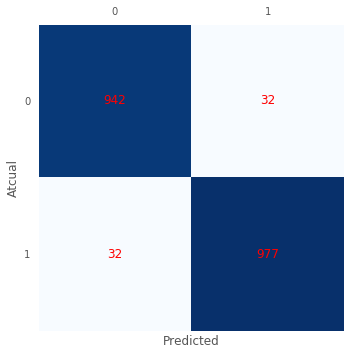

In [9]:
print('Best C : %f'%best_C)
print('Log Loss : %f'%least_loss)
print('Accuracy : %f'%accuracy)
print('Confusion Matrix : ')
with plt.style.context(('seaborn', 'ggplot')):
    plt.matshow(conf_mat, cmap=plt.cm.Blues)
    plt.grid(None)
    plt.xlabel('Predicted')
    plt.ylabel("Atcual")
    for i in range(2):
        for j in range(2):
            plt.text(j,i,str(conf_mat[i,j]), color='red', fontsize=12, horizontalalignment='center', verticalalignment='center')

In [10]:
best_model

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
preds = best_model.predict(X_test)
false_predictions_index = [i for i, val in enumerate(preds != Y_test.flatten()) if val]

In [12]:
false_positives, false_negatives = [], []
for idx in false_predictions_index:
    if Y_test[idx] == 1 and preds[idx] == 0:
        false_negatives.append(idx)
    elif Y_test[idx] == 0 and preds[idx] == 1:
        false_positives.append(idx)

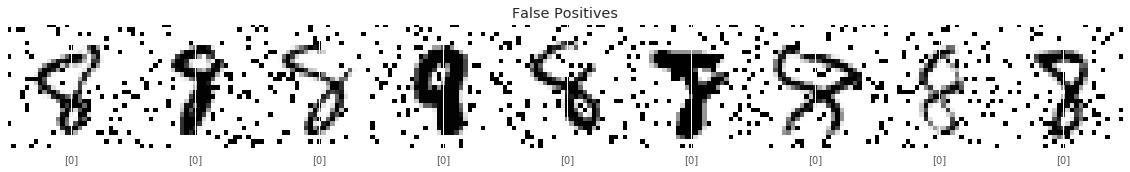

In [13]:
with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(20,4))
    images = []
    for idx in false_positives[:9]:
        images.append(X_test[idx].reshape(28,28))
    combined_images = np.hstack(images)
    plt.imshow(combined_images, cmap=plt.cm.Greys, vmin=0.0, vmax=1.0 )
    plt.xticks(range(14,252,28), Y_test[false_positives[:9]])
    plt.yticks([])
    plt.title('False Positives')

It seems that data has mixed 8 and 9 as in class 0. We feel that model is not making much mistake as mistakes seems to be with test data. It has images of class 1 in class 0.

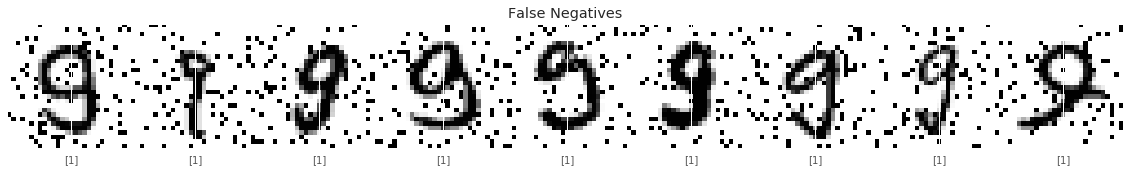

In [14]:
with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(20,4))
    images = []
    for idx in false_negatives[:9]:
        images.append(X_test[idx].reshape(28,28))
    combined_images = np.hstack(images)
    plt.imshow(combined_images, cmap=plt.cm.Greys, vmin=0.0, vmax=1.0 )
    plt.xticks(range(14,252,28), Y_test[false_negatives[:9]])
    plt.yticks([])
    plt.title('False Negatives')

It seems that data has mixed 8 and 9 as in class 1. We feel that model is not making much mistake as mistakes seems to be with test data. It has images of class 0 in class 1.

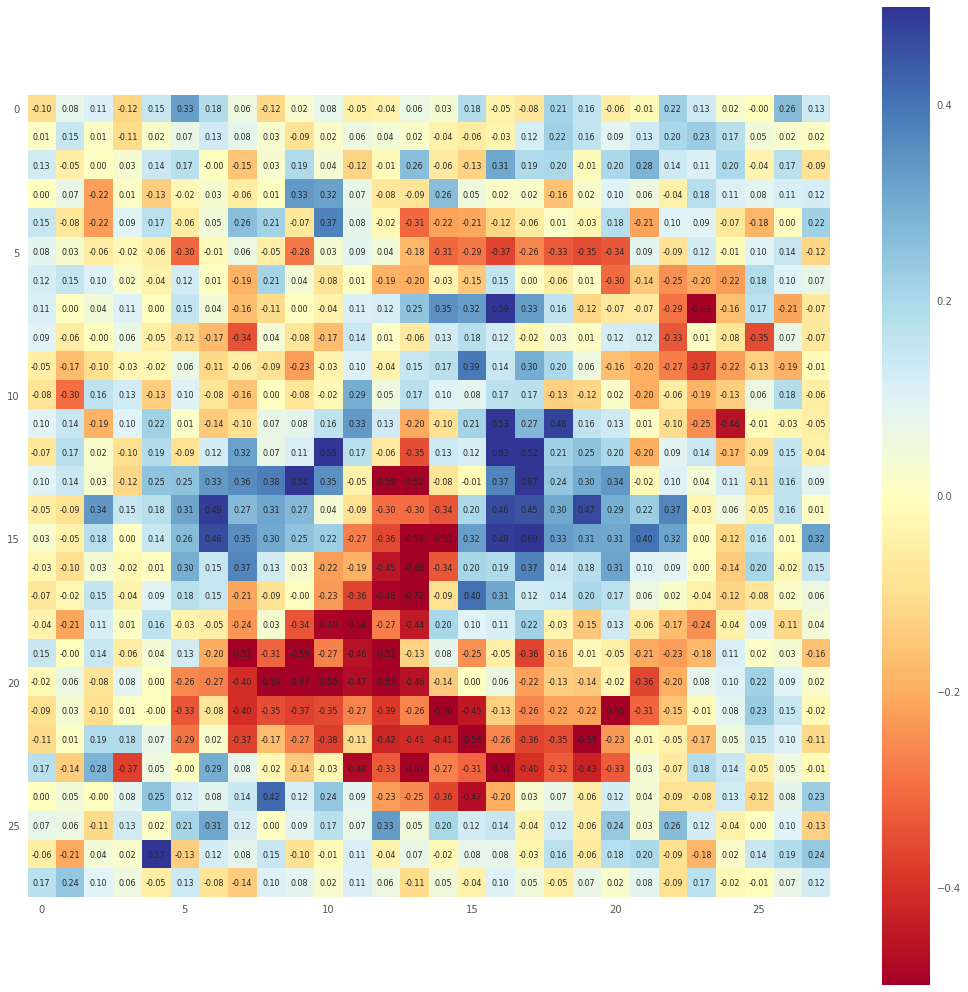

In [15]:
with plt.style.context(('seaborn', 'ggplot')):
    weights = best_model.coef_.reshape(28,28)
    plt.figure(figsize=(18,18))
    plt.imshow(weights, cmap='RdYlBu', vmin=-0.5, vmax=0.5)
    plt.grid(None)
    plt.colorbar()
    for i in range(28):
        for j in range(28):
            plt.text(j,i , '%.2f'%weights[i,j], horizontalalignment='center', verticalalignment='center', fontsize=8)

Pixels which are above middle has most positive weights and middle below has negative weights. We feel that it has happened because of presence of both images of 8 and 9 in both classes. Dataset seems quite noisy due to missing up of class images.

# Sneakars vs Sandals

In [16]:
X_train = pd.read_csv(os.path.join(root_dir, 'data_sneaker_vs_sandal/x_train.csv')).values
X_test = pd.read_csv(os.path.join(root_dir, 'data_sneaker_vs_sandal/x_test.csv')).values
Y_train = pd.read_csv(os.path.join(root_dir, 'data_sneaker_vs_sandal/y_train.csv')).values

print('Train/Test Sizes : ',X_train.shape, X_test.shape, Y_train.shape)

Train/Test Sizes :  (12000, 784) (2000, 784) (12000, 1)


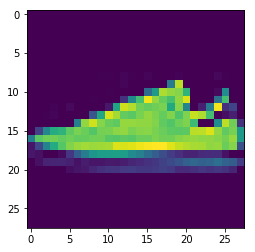

In [17]:
plt.imshow(X_train[0].reshape(28,28));

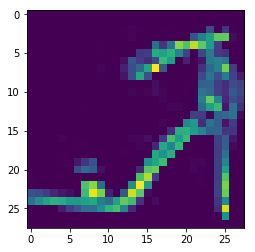

In [18]:
plt.imshow(X_train[1].reshape(28,28));

In [19]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)
loss1 = log_loss(Y_train, lr.predict(X_train))
acc1 = lr.score(X_train, Y_train)

print('Train Accuracy : ', acc1)
print('Train Loss : ',loss1)

Train Accuracy :  0.9735
Train Loss :  0.915287103001177


In [20]:
preds = lr.predict(X_train)
false_predictions_index = [i for i, val in enumerate(preds != Y_train.flatten()) if val]
false_positives, false_negatives = [], []
for idx in false_predictions_index:
    if Y_train[idx] == 1 and preds[idx] == 0:
        false_negatives.append(idx)
    elif Y_train[idx] == 0 and preds[idx] == 1:
        false_positives.append(idx)

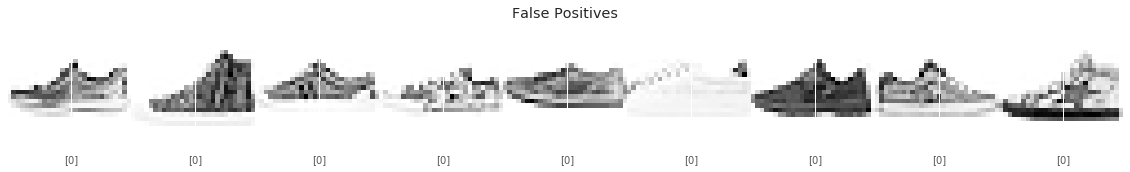

In [21]:
with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(20,4))
    images = []
    for idx in false_positives[:9]:
        images.append(X_train[idx].reshape(28,28))
    combined_images = np.hstack(images)
    plt.imshow(combined_images, cmap=plt.cm.Greys, vmin=0.0, vmax=1.0 )
    plt.xticks(range(14,252,28), Y_train[false_positives[:9]])
    plt.yticks([])
    plt.title('False Positives')

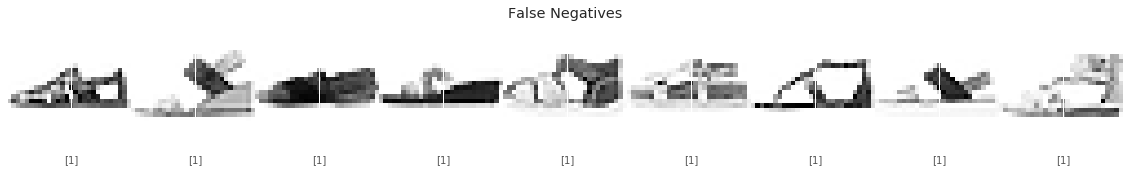

In [22]:
with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(20,4))
    images = []
    for idx in false_negatives[:9]:
        images.append(X_train[idx].reshape(28,28))
    combined_images = np.hstack(images)
    plt.imshow(combined_images, cmap=plt.cm.Greys, vmin=0.0, vmax=1.0 )
    plt.xticks(range(14,252,28), Y_train[false_negatives[:9]])
    plt.yticks([])
    plt.title('False Negatives')

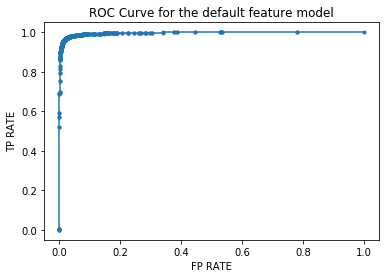

In [23]:
fpr, tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train)[:, 1])
plt.title("ROC Curve for the default feature model")
plt.ylabel('TP RATE')
plt.xlabel('FP RATE')
plt.plot(fpr, tpr, marker='.')
plt.show()

In [24]:
np.savetxt('yproba1_test_1.txt', np.clip(lr.predict_proba(X_test)[:, 1],0.020, 0.980), fmt='%.3f')

## Data Augmentation
* rotating images by 30 degree
* height/width shifting
* Horizontal flipping

In [25]:
datagen_train = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=30,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    horizontal_flip=True)
datagen_train.fit(X_train.reshape(X_train.shape[0], 1,28,28))

In [26]:
%%time

all_imgs_train, all_labels_train = [], []
for i, (images, labels) in enumerate(datagen_train.flow(X_train.reshape(X_train.shape[0], 1,28,28), Y_train, batch_size=1000)):
    all_imgs_train.append(images)
    all_labels_train.append(labels)
    if i == 19:
        break

CPU times: user 20.9 s, sys: 56 ms, total: 20.9 s
Wall time: 20.9 s


In [27]:
X_train_aug = np.vstack(all_imgs_train)
Y_train_aug = np.vstack(all_labels_train)

X_train_aug = np.squeeze(X_train_aug)
X_train_aug.shape, Y_train_aug.shape, X_test.shape

((20000, 28, 28), (20000, 1), (2000, 784))

In [28]:
X_train_aug = X_train_aug.reshape(X_train_aug.shape[0], 784)
X_train_aug.shape, X_test.shape

((20000, 784), (2000, 784))

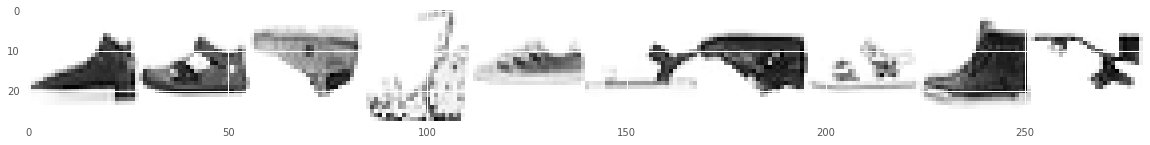

In [29]:
with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(20,7))
    combined_images = []
    for img in X_train_aug[12000:12010]:
        combined_images.append(img.reshape(28,28))
    combined_images = np.hstack(combined_images)
    plt.imshow(combined_images, cmap=plt.cm.Greys, vmin=0.0, vmax=1.0 )

In [30]:
lr = LogisticRegression()
lr.fit(X_train_aug, Y_train_aug)
acc2 = lr.score(X_train_aug, Y_train_aug)
loss2 = log_loss(Y_train_aug, lr.predict(X_train_aug))
                 
print('Train Accuracy : ',acc2)
print('Train Loss : ',loss2)
np.savetxt('yproba1_test_augmentation1.txt', np.clip(lr.predict_proba(X_test)[:, 1],0.020, 0.980), fmt='%.3f')

Train Accuracy :  0.9641
Train Loss :  1.2399548661361774


In [31]:
preds = lr.predict(X_train_aug)
false_predictions_index = [i for i, val in enumerate(preds != Y_train_aug.flatten()) if val]
false_positives, false_negatives = [], []
for idx in false_predictions_index:
    if Y_train_aug[idx] == 1 and preds[idx] == 0:
        false_negatives.append(idx)
    elif Y_train_aug[idx] == 0 and preds[idx] == 1:
        false_positives.append(idx)

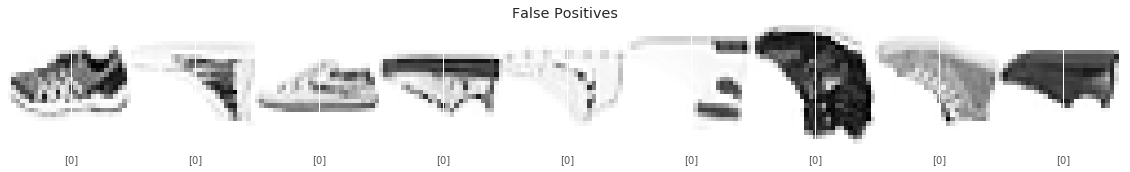

In [32]:
with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(20,4))
    images = []
    for idx in false_positives[:9]:
        images.append(X_train_aug[idx].reshape(28,28))
    combined_images = np.hstack(images)
    plt.imshow(combined_images, cmap=plt.cm.Greys, vmin=0.0, vmax=1.0 )
    plt.xticks(range(14,252,28), Y_train_aug[false_positives[:9]])
    plt.yticks([])
    plt.title('False Positives')

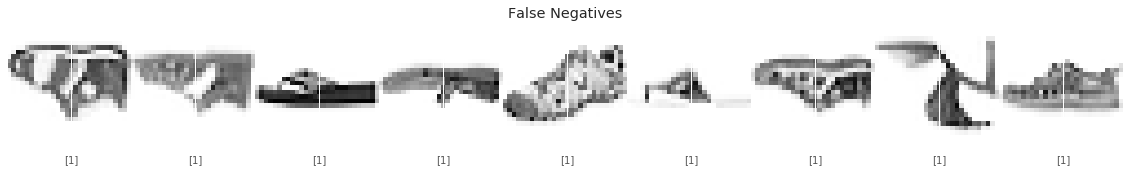

In [33]:
with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(20,4))
    images = []
    for idx in false_negatives[:9]:
        images.append(X_train_aug[idx].reshape(28,28))
    combined_images = np.hstack(images)
    plt.imshow(combined_images, cmap=plt.cm.Greys, vmin=0.0, vmax=1.0 )
    plt.xticks(range(14,252,28), Y_train_aug[false_negatives[:9]])
    plt.yticks([])
    plt.title('False Negatives')

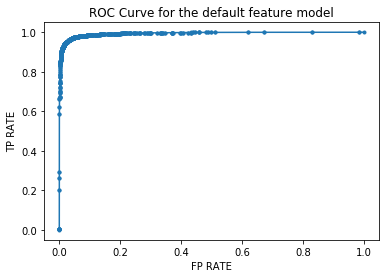

In [34]:
fpr, tpr, thresholds = roc_curve(Y_train_aug, lr.predict_proba(X_train_aug)[:, 1])
plt.title("ROC Curve for the default feature model")
plt.ylabel('TP RATE')
plt.xlabel('FP RATE')
plt.plot(fpr, tpr, marker='.')
plt.show()

## AverageValueFeatureExtractor

In [35]:
class AverageValueFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def transform(self, x, y=None):
        return np.sum(x, axis=1)[:,np.newaxis]
    def fit(self, x, y=None):
        return self

In [36]:
sfe = AverageValueFeatureExtractor() 
X_train_ave = sfe.transform(X_train)
X_test_ave = sfe.transform(X_test)
lr = LogisticRegression()
lr.fit(X_train_ave, Y_train)

acc3 = lr.score(X_train_ave, Y_train)
loss3 = log_loss(Y_train, lr.predict(X_train_ave))
                 
print('Train Accuracy : ',acc3)
print('Train Loss : ',loss3)
np.savetxt('yproba1_test_average_value1.txt', np.clip(lr.predict_proba(X_test_ave)[:, 1],0.020, 0.980), fmt='%.3f')

Train Accuracy :  0.62
Train Loss :  13.124898681006773


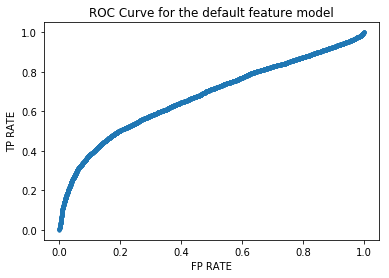

In [37]:
fpr, tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_ave)[:, 1])
plt.title("ROC Curve for the default feature model")
plt.ylabel('TP RATE')
plt.xlabel('FP RATE')
plt.plot(fpr, tpr, marker='.')
plt.show()

## SquaredFeatureExtractor

In [38]:
class SquaredFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def transform(self, x, y=None):
        return np.square(x)

    def fit(self, x, y=None):
        return self

In [39]:
sfe = SquaredFeatureExtractor() 
X_train_sfe = sfe.transform(X_train)
X_test_sfe = sfe.transform(X_test)
lr = LogisticRegression()
lr.fit(X_train_sfe, Y_train)

acc4 = lr.score(X_train, Y_train)
loss4 = log_loss(Y_train, lr.predict(X_train_sfe))
                 
print('Train Accuracy : ',acc4)
print('Train Loss : ',loss4)
np.savetxt('yproba1_test_squared_feature1.txt', np.clip(lr.predict_proba(X_test_sfe)[:, 1],0.020, 0.980), fmt='%.3f')

Train Accuracy :  0.9605833333333333
Train Loss :  1.5082106937883264


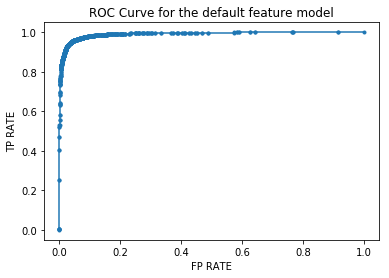

In [40]:
fpr, tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_sfe)[:, 1])
plt.title("ROC Curve for the default feature model")
plt.ylabel('TP RATE')
plt.xlabel('FP RATE')
plt.plot(fpr, tpr, marker='.')
plt.show()

### Min Max Scaler Transformation

In [41]:
scaler = MinMaxScaler()
X_train_min_max = scaler.fit_transform(X_train)
X_test_min_max = scaler.transform(X_test)

print(X_train_min_max.shape, X_test_min_max.shape)

(12000, 784) (2000, 784)


In [42]:
lr = LogisticRegression()
lr.fit(X_train_min_max, Y_train)
acc5 = lr.score(X_train_min_max, Y_train)
loss5 = log_loss(Y_train, lr.predict(X_train_min_max))
                 
print('Train Accuracy : ',acc5)
print('Train Loss : ',loss5)
np.savetxt('yproba1_test_min_maxscaler.txt', np.clip(lr.predict_proba(X_test_min_max)[:, 1],0.020, 0.980), fmt='%.3f')

Train Accuracy :  0.97375
Train Loss :  0.906652275636211


In [43]:
preds = lr.predict(X_train_min_max)
false_predictions_index = [i for i, val in enumerate(preds != Y_train.flatten()) if val]
false_positives, false_negatives = [], []
for idx in false_predictions_index:
    if Y_train[idx] == 1 and preds[idx] == 0:
        false_negatives.append(idx)
    elif Y_train[idx] == 0 and preds[idx] == 1:
        false_positives.append(idx)

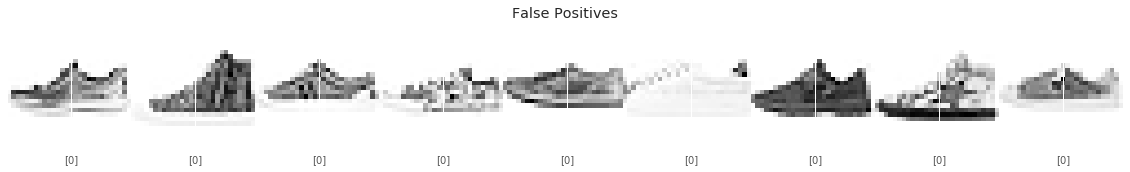

In [44]:
with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(20,4))
    images = []
    for idx in false_positives[:9]:
        images.append(X_train_min_max[idx].reshape(28,28))
    combined_images = np.hstack(images)
    plt.imshow(combined_images, cmap=plt.cm.Greys, vmin=0.0, vmax=1.0 )
    plt.xticks(range(14,252,28), Y_train[false_positives[:9]])
    plt.yticks([])
    plt.title('False Positives')

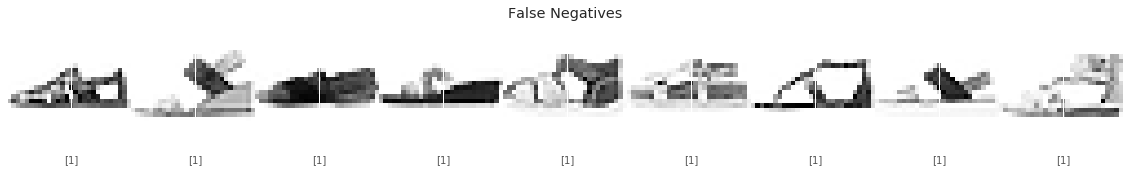

In [45]:
with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(20,4))
    images = []
    for idx in false_negatives[:9]:
        images.append(X_train_min_max[idx].reshape(28,28))
    combined_images = np.hstack(images)
    plt.imshow(combined_images, cmap=plt.cm.Greys, vmin=0.0, vmax=1.0 )
    plt.xticks(range(14,252,28), Y_train[false_negatives[:9]])
    plt.yticks([])
    plt.title('False Negatives')

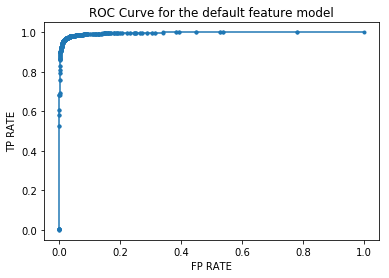

In [46]:
fpr, tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train)[:, 1])
plt.title("ROC Curve for the default feature model")
plt.ylabel('TP RATE')
plt.xlabel('FP RATE')
plt.plot(fpr, tpr, marker='.')
plt.show()

## PCA Transformation

In [47]:
pca = PCA(n_components=int(X_train.shape[1]*0.80))
X_train_pca1 = pca.fit_transform(X_train)
X_test_pca1 = pca.fit_transform(X_test)
X_train_pca1.shape, X_test_pca1.shape

((12000, 627), (2000, 627))

In [48]:
lr = LogisticRegression()
lr.fit(X_train_pca1, Y_train)
acc6 = lr.score(X_train_pca1, Y_train)
loss6 = log_loss(Y_train, lr.predict(X_train_pca1))
                 
print('Train Accuracy : ',acc6)
print('Train Loss : ',loss6)
np.savetxt('yproba1_test_pca1.txt', np.clip(lr.predict_proba(X_test_pca1)[:, 1],0.020, 0.980), fmt='%.3f')

Train Accuracy :  0.97375
Train Loss :  0.9066523422693302


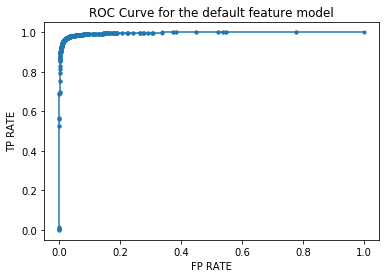

In [49]:
fpr, tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_pca1)[:, 1])
plt.title("ROC Curve for the default feature model")
plt.ylabel('TP RATE')
plt.xlabel('FP RATE')
plt.plot(fpr, tpr, marker='.')
plt.show()

In [50]:
pca = PCA(n_components=int(X_train.shape[1]*0.50))
X_train_pca2 = pca.fit_transform(X_train)
X_test_pca2 = pca.fit_transform(X_test)
X_train_pca2.shape, X_test_pca2.shape

((12000, 392), (2000, 392))

In [51]:
lr = LogisticRegression()
lr.fit(X_train_pca2, Y_train)
acc7 = lr.score(X_train_pca2, Y_train)
loss7 = log_loss(Y_train, lr.predict(X_train_pca2))
                 
print('Train Accuracy : ', acc7)
print('Train Loss : ', loss7)
np.savetxt('yproba1_test_pca2.txt', np.clip(lr.predict_proba(X_test_pca2)[:, 1],0.020, 0.980), fmt='%.3f')

Train Accuracy :  0.9715
Train Loss :  0.9843652554890711


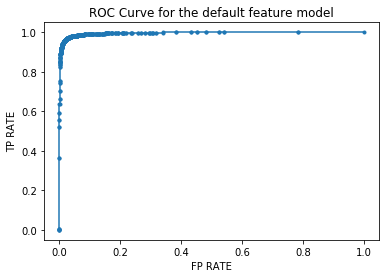

In [52]:
fpr, tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_pca2)[:, 1])
plt.title("ROC Curve for the default feature model")
plt.ylabel('TP RATE')
plt.xlabel('FP RATE')
plt.plot(fpr, tpr, marker='.')
plt.show()

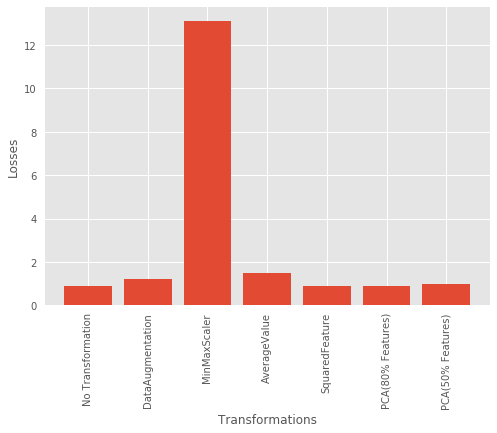

In [53]:
with plt.style.context(('seaborn', 'ggplot')):
    plt.bar([0,1,2,3,4,5,6], [loss1,loss2,loss3, loss4, loss5,loss6,loss7], width = 0.8)
    plt.xticks([0,1,2,3,4,5,6],['No Transformation', 'DataAugmentation', 'MinMaxScaler', 'AverageValue', 'SquaredFeature', 'PCA(80% Features)', 'PCA(50% Features)'], rotation='vertical')
    plt.xlabel('Transformations')
    plt.ylabel('Losses')

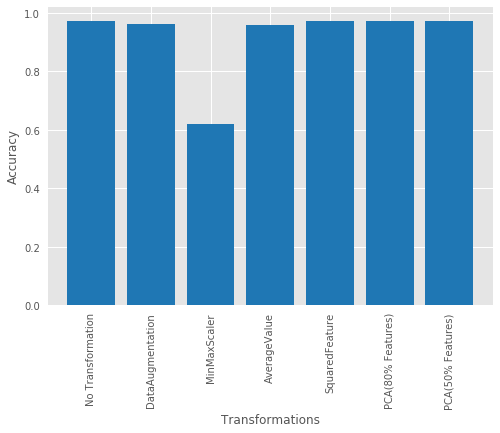

In [54]:
with plt.style.context(('seaborn', 'ggplot')):
    plt.bar([0,1,2,3,4,5,6], [acc1,acc2,acc3,acc4,acc5,acc6,acc7], width = 0.8, color='tab:blue')
    plt.xticks([0,1,2,3,4,5,6],['No Transformation', 'DataAugmentation', 'MinMaxScaler', 'AverageValue', 'SquaredFeature', 'PCA(80% Features)', 'PCA(50% Features)'], rotation='vertical')
    plt.xlabel('Transformations')
    plt.ylabel('Accuracy')